In [98]:
import numpy as np
import pandas as pd
import warnings
import math

from grmpy.check.check import check_presence_estimation_dataset
from grmpy.check.check import check_initialization_dict
from grmpy.check.check import check_presence_init
from grmpy.check.auxiliary import read_data
from grmpy.read.read import read

from semipar.estimation.estimate_auxiliary import estimate_treatment_propensity
from semipar.estimation.estimate_auxiliary import define_common_support
from semipar.estimation.estimate_auxiliary import double_residual_reg
from semipar.estimation.estimate_auxiliary import construct_Xp
from semipar.estimation.estimate_auxiliary import trim_data

from semipar.KernReg.locpoly import locpoly
from sklearn.utils import resample
from scipy.stats import norm

In [99]:
warnings.filterwarnings('ignore')

In [100]:
# Data preparation
def process_mock_df(df, output_file):
    """This function adds squared and interaction terms to the Carneiro data set."""

    # Delete redundant columns\n",
    for key_ in ["newid", "caseid"]:
        del df[key_]

    # Add squared terms
    for key_ in ["mhgc", "cafqt", "avurate", "lurate_17", "numsibs", "lavlocwage17"]:
        str_ = key_ + "sq"
        df[str_] = df[key_] ** 2

    # Add interaction terms
    for j in ["pub4", "lwage5_17", "lurate_17", "tuit4c"]:
        for i in ["cafqt", "mhgc", "numsibs"]:
            df[j + i] = df[j] * df[i]
    
    # save output_file
    df.to_pickle(output_file + ".pkl")

In [101]:
basic = pd.read_stata('semipar/data/basicvariables.dta')
local = pd.read_stata('semipar/data/localvariables.dta')
df = pd.concat([basic, local], axis = 1)
process_mock_df(df,'semipar/data/aer-replication-mock')

In [107]:
def bootstrap_se(init_file, nbootstraps):
    """
    This function generates bootsrapped standard errors
    given an init_file and the number of bootsraps to be drawn.
    """
    check_presence_init(init_file)

    dict_ = read(init_file)
    # np.random.seed(dict_["SIMULATION"]["seed"]) # needed?

    check_presence_estimation_dataset(dict_)
    check_initialization_dict(dict_)

    nbins = dict_["ESTIMATION"]["nbins"]
    trim = dict_["ESTIMATION"]["trim_support"]
    rbandwidth = dict_["ESTIMATION"]["rbandwidth"]
    bandwidth = dict_["ESTIMATION"]["bandwidth"]
    gridsize = dict_["ESTIMATION"]["gridsize"]
    a = dict_["ESTIMATION"]["ps_range"][0]
    b = dict_["ESTIMATION"]["ps_range"][1]

    logit = dict_["ESTIMATION"]["logit"]
    show_output = dict_["ESTIMATION"]["show_output"]
    
    # Distribute initialization information.
    data = read_data(dict_["ESTIMATION"]["file"])
    
    # Prepare empty arrays to store output values
    mte_4 = np.zeros([gridsize, nbootstraps])
    quantiles = np.zeros([gridsize, nbootstraps])
    
    for i in range(nbootstraps): 
        boot = resample(data, replace=True, n_samples=len(data), random_state=None)
        
         # Process data for the semiparametric estimation.
        indicator = dict_["ESTIMATION"]["indicator"]
        D = boot[indicator].values
        Z = boot[dict_["CHOICE"]["order"]]

        # The Local Instrumental Variables (LIV) approach

        # 1. Estimate propensity score P(z)
        ps = estimate_treatment_propensity(D, Z, logit, show_output)

        # 2a. Find common support
        treated, untreated, common_support = define_common_support(
            ps, indicator, boot, nbins, show_output
        )

        # 2b. Trim the data
        if trim is True:
            boot, ps = trim_data(ps, common_support, boot, show_output)

        # 3. Double Residual Regression
        # Sort data by ps
        boot = boot.sort_values(by="ps", ascending=True)
        ps = np.sort(ps)

        X = boot[dict_["TREATED"]["order"]]
        Xp = construct_Xp(X, ps)
        Y = boot[["wage"]]

        b0, b1_b0 = double_residual_reg(ps, X, Xp, Y, rbandwidth, show_output)

        # Turn the X, Xp, and Y DataFrames into np.ndarrays
        X_arr = np.array(X)
        Xp_arr = np.array(Xp)
        Y_arr = np.array(Y).ravel()

        # 4. Compute the unobserved part of Y
        Y_tilde = Y_arr - np.dot(X_arr, b0) - np.dot(Xp_arr, b1_b0)

        # 5. Estimate mte_u, the unobserved component of the MTE,
        # through a locally quadratic regression
        quantiles, mte_u = locpoly(ps, Y_tilde, 1, 2, bandwidth, gridsize, a, b)

        # 6. construct MTE
        # Calculate the MTE component that depends on X
        mte_x = np.dot(X, b1_b0).mean(axis=0)

        # Put the MTE together
        mte = mte_x + mte_u
        mte_4 = mte / 4
        
        mte_4_out[:,i] = mte / 4
      
    # 
    mte_mean = mte_4_out.mean(axis=1)
    no_sum = np.zeros([len(mte_4_out), nbootstraps])

    for row in range(len(mte_4_out)):
        for column in range(nbootstraps):
            no_sum[row,column] = ((mte_4_out[row,column] - mte_mean[row])**2)

    se_out = (1 / (nbootstraps - 1)) * np.sum(no_sum, axis=1)
        
    return mte_4_out, se_out

In [106]:
# Draw bootsraps and calculate standard errors for the 250 MTE estimates.
# Note that the MTEs are divided by 4 to get an estimate of the benefits of one 
# additional year of college education rather than the benefits of obtaining a 4-year college degree.
mte_4_out, se_out = bootstrap_se('semipar/files/replication.bootstrap.yml', 250)

In [113]:
# Use original data set to replicate the results from Carneiro et al (2011)
quantiles, mte_u, mte_x, mte = semipar_fit("semipar/files/replication.bootstrap.yml")
mte_4 = mte / 4

In [114]:
# Compute 90 percent confidence intervals
con_u = mte_4 + norm.ppf(0.95) * se_out
con_d = mte_4 - norm.ppf(0.95) * se_out

In [115]:
# import original results
mte_ = pd.read_csv('semipar/data/mte_semipar_original.csv')

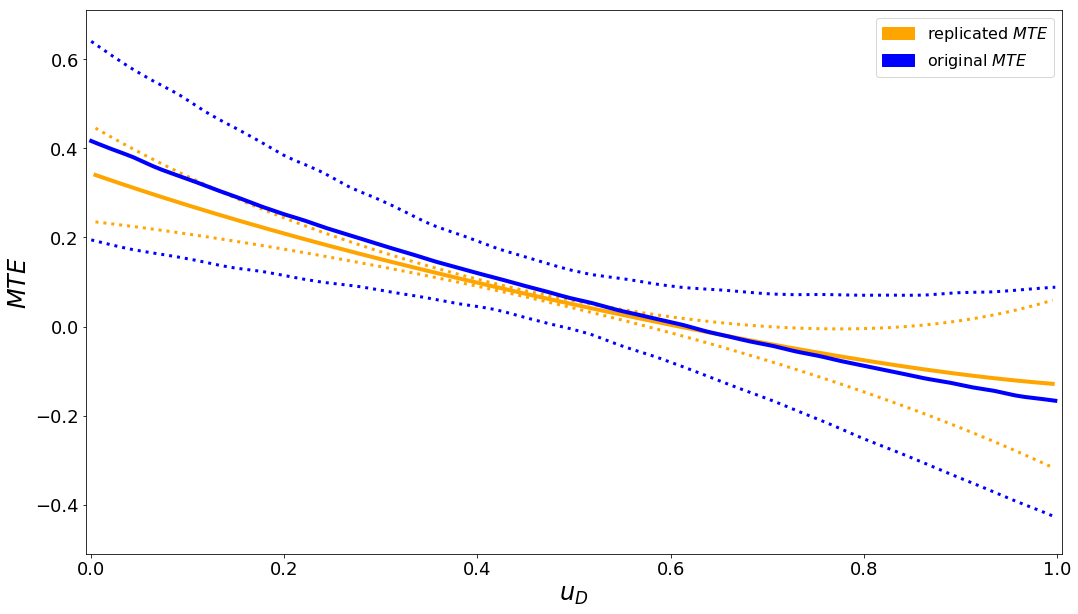

In [116]:
# Plot
ax = plt.figure(figsize=(17.5, 10)).add_subplot(111)

ax.set_ylabel(r"$MTE$", fontsize=24)
ax.set_xlabel("$u_D$", fontsize=24)
ax.tick_params(axis="both", which="major", labelsize=18)

# Plot replicated curves
ax.plot(quantiles, mte_4, label="replicated $MTE$", color="orange", linewidth=4)

# ax.plot(quantiles_R, mte_4_R, label="replicated $MTE$, R loess residuals", color="green", linewidth=4)

ax.plot(quantiles, con_u, color="orange", linestyle=":", linewidth=3)
ax.plot(quantiles, con_d, color="orange", linestyle=":", linewidth=3)


# Plot original curve
ax.plot(mte_['quantiles'], mte_['mte'], label="$original MTE$", color="blue", linewidth=4)
ax.plot(mte_['quantiles'], mte_['con_u'], color="blue", linestyle=":", linewidth=3)
ax.plot(mte_['quantiles'], mte_['con_d'], color="blue", linestyle=":", linewidth=3)

ax.set_ylim([-0.51, 0.71])
ax.set_xlim([-0.005, 1.005])

blue_patch = mpatches.Patch(color="orange", label="replicated $MTE$")
orange_patch = mpatches.Patch(color="blue", label="original $MTE$")
plt.legend(handles=[blue_patch, orange_patch], prop={"size": 16})
plt.show()